# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. 


### The Model
We start with the model.

In [1]:
import time
import datetime

run_data = {} # used for code profiling

run_data['Date'] = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
run_data['Global Start Time'] = time.time()

In [2]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

### The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST datasets, balanced the way the gods intended, and we make datatloaders from them. Nothing exciting to see here. This is our baseline. If you don't already have the MNIST data on your machine, the calls to `torchvision.datasets.MNIST(... dowload=True ...)` will download it for you.

In [3]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [4]:
# create dataloaders

from torch.utils.data import DataLoader

run_data['Batch Size'] = batch_size = 128

# create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

Let's check out the goods. We expect than the out-of-the-box MNIST dataset will have roughly equal numbers of samples for each numeral.

In [5]:
from collections import Counter
import numpy as np
#import statistics

train_counts = Counter(int(y) for y in train_dset.targets).most_common()
print("Train counts: \n", train_counts)
print("Train mean: %.2f" % np.mean(list(zip(*train_counts))[1]))
print("Train stdev: %.2f" % np.std(list(zip(*train_counts))[1]))
#print('stat.stdev', statistics.stdev(list(zip(*train_counts))[1])) # WTF MLW?
#print("Train var: %.2f" % np.var(list(zip(*train_counts))[1])) # WTF MLW?
print("Train CV: %.2f" % (float(np.mean(list(zip(*train_counts))[1])) / float(np.std(list(zip(*train_counts))[1]))))

print()

test_counts = Counter(int(y) for y in test_dset.targets).most_common()
print("Test counts: \n", test_counts)
print("Test mean: %.2f" % np.mean(list(zip(*test_counts))[1]))
print("Test stdev: %.2f" % np.std(list(zip(*test_counts))[1]))
print("Test CV: %.2f" % (float(np.mean(list(zip(*test_counts))[1])) / float(np.std(list(zip(*test_counts))[1]))))

Train counts: 
 [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]
Train mean: 6000.00
Train stdev: 322.08
Train CV: 18.63

Test counts: 
 [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]
Test mean: 1000.00
Test stdev: 59.20
Test CV: 16.89


The training data looks reasonably well distributed, and the plots below confirm it.

TODO: Use a better metric of distribution? std?

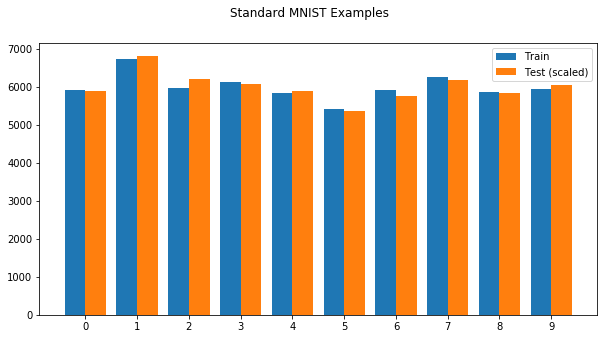

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Standard MNIST Examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

NOTE: DO WE WANT TO JUST TRAIN THE BASELINE MODEL HERE BEFORE STACKING THE DECK?

AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

### Stacking a Deck (Skewing the Data)

We know the baseline data is pretty even across numerals. Now we need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [7]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [8]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

### 

Here we do the sampling to create our skewed datasets.

In [9]:
from tqdm import tqdm

# create stacked loaders for the workers

run_data['Skew Bias'] = skew_bias = 0.5
run_data['Examples Per Skewed Loader'] = loader_size = 1024
run_data['Number of Workers'] = num_workers = 3

stacking_start_time = time.time()

stacked_data_loaders = []
for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label%10], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

run_data['Stacking Time'] = time.time() - stacking_start_time
run_data['Stacking Time per Loader'] = run_data['Stacking Time'] / run_data['Number of Workers']

print('Stacking Time: %.2f' % run_data['Stacking Time'])
print('Stacking Time per Loader: %.2f' % run_data['Stacking Time per Loader'])

100%|██████████| 3/3 [00:27<00:00,  9.45s/it]

Stacking Time: 27.91
Stacking Time per Loader: 9.30


We should see the effect of the skew in a count and histogram of a skewed dataset. Here, we arbitrarily picked the second dataloader.

In [10]:
_, ybatches = list(zip(*stacked_data_loaders[1]))
ys = torch.cat(ybatches)
ys = [int(y) for y in ys]
print (Counter(ys).most_common())

# counts = sorted(Counter(ys).most_common())
# print(counts)
# _, counts = zip(*counts)
# print(list(counts))


[(1, 212), (9, 106), (2, 101), (8, 96), (7, 95), (3, 88), (6, 85), (0, 83), (5, 82), (4, 76)]


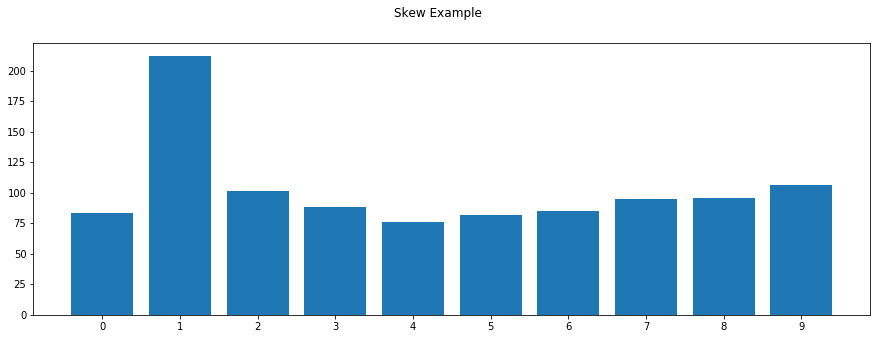

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [12]:
hist_counts = []
digit_counts = []
for loader in tqdm(stacked_data_loaders):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


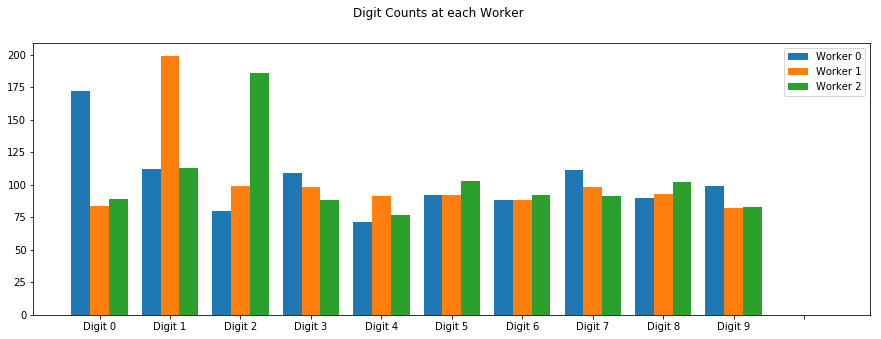

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Counts at each Worker')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels([('Digit ' + str(x-1)) for x in range(11)])
ax.hist(hist_counts, 
        label=[('Worker ' + str(x)) for x in range(num_workers)],
        bins=list(range(12)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       );
ax.legend();

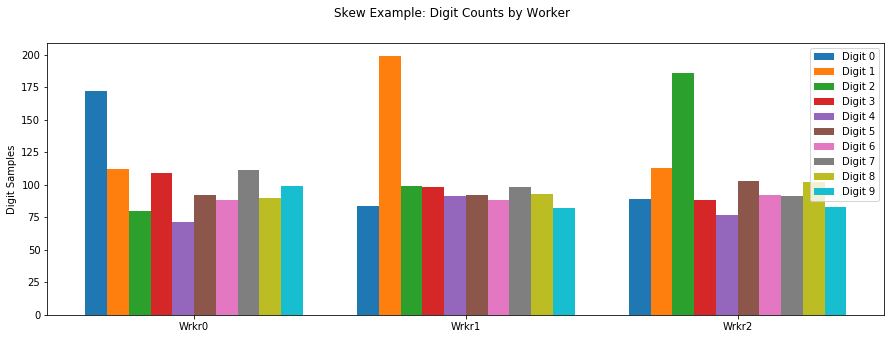

In [14]:
# fig, ax = plt.subplots(figsize=(15, 5))
# fig.suptitle('Skew Examples')
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.hist(digit_counts, 
#         label=[('Digit ' + str(x)) for x in range(11)],
#         bins=num_workers + 1, 
#         histtype='bar',
#         align='left',
#         rwidth=0.8,
#        );
# ax.legend();



fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example: Digit Counts by Worker')

pos = list(range(num_workers))
width = 0.08

for digit in range(10):
    ax.bar([p + (width * digit) for p in pos],
           digit_counts[digit],
           width = width,
           label = 'Digit ' + str(digit),
          )

ax.set_xticks([p + (4.5 * width) for p in pos])
ax.set_xticklabels([('Wrkr' + str(x)) for x in range(num_workers)])
ax.set_ylabel('Digit Samples')
ax.legend(loc = 'upper right');

In [15]:
import federated

run_data['Learning Rate'] = learning_rate = 1e-2
run_data['Epochs per Round'] = num_epochs = 1
run_data['Federated Training Rounds'] = num_rounds = 100

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [16]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
#run_data['Manager Loss History'] = manager.manager_loss_history
#run_data['Worker Loss Histories'] = manager.worker_loss_histories
run_data['Final Global Loss'] = manager.manager_loss_history[-1]

print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

  0%|          | 0/100 [00:00<?, ?it/s]

Training 100 round(s) with 3 worker(s) doing 1 epoch(s) per round.

Beginning round 1
	Worker: 8952 	local loss: 2.2923
	Worker: 2464 	local loss: 2.2979
	Worker: 7624 	local loss: 2.2899


  1%|          | 1/100 [00:05<09:05,  5.51s/it]

Finished round 1 with global loss: 2.29718 

Beginning round 2
	Worker: 8952 	local loss: 2.2745
	Worker: 2464 	local loss: 2.2819
	Worker: 7624 	local loss: 2.2820


  2%|▏         | 2/100 [00:11<08:59,  5.51s/it]

Finished round 2 with global loss: 2.29174 

Beginning round 3
	Worker: 8952 	local loss: 2.2890
	Worker: 2464 	local loss: 2.2858
	Worker: 7624 	local loss: 2.2813


  3%|▎         | 3/100 [00:16<08:53,  5.50s/it]

Finished round 3 with global loss: 2.28664 

Beginning round 4
	Worker: 8952 	local loss: 2.2717
	Worker: 2464 	local loss: 2.2663
	Worker: 7624 	local loss: 2.2774


  4%|▍         | 4/100 [00:22<08:52,  5.54s/it]

Finished round 4 with global loss: 2.28144 

Beginning round 5
	Worker: 8952 	local loss: 2.2520
	Worker: 2464 	local loss: 2.2653
	Worker: 7624 	local loss: 2.2745


  5%|▌         | 5/100 [00:27<08:43,  5.51s/it]

Finished round 5 with global loss: 2.27637 

Beginning round 6
	Worker: 8952 	local loss: 2.2672
	Worker: 2464 	local loss: 2.2494
	Worker: 7624 	local loss: 2.2537


  6%|▌         | 6/100 [00:33<08:35,  5.49s/it]

Finished round 6 with global loss: 2.27137 

Beginning round 7
	Worker: 8952 	local loss: 2.2576
	Worker: 2464 	local loss: 2.2308
	Worker: 7624 	local loss: 2.2606


  7%|▋         | 7/100 [00:38<08:32,  5.51s/it]

Finished round 7 with global loss: 2.26614 

Beginning round 8
	Worker: 8952 	local loss: 2.2416
	Worker: 2464 	local loss: 2.2429
	Worker: 7624 	local loss: 2.2461


  8%|▊         | 8/100 [00:44<08:25,  5.50s/it]

Finished round 8 with global loss: 2.26086 

Beginning round 9
	Worker: 8952 	local loss: 2.2481
	Worker: 2464 	local loss: 2.2249
	Worker: 7624 	local loss: 2.2473


  9%|▉         | 9/100 [00:49<08:19,  5.49s/it]

Finished round 9 with global loss: 2.25556 

Beginning round 10
	Worker: 8952 	local loss: 2.2270
	Worker: 2464 	local loss: 2.2279
	Worker: 7624 	local loss: 2.2439


 10%|█         | 10/100 [00:54<08:13,  5.49s/it]

Finished round 10 with global loss: 2.24994 

Beginning round 11
	Worker: 8952 	local loss: 2.2252
	Worker: 2464 	local loss: 2.2116
	Worker: 7624 	local loss: 2.2229


 11%|█         | 11/100 [01:00<08:07,  5.48s/it]

Finished round 11 with global loss: 2.24422 

Beginning round 12
	Worker: 8952 	local loss: 2.2301
	Worker: 2464 	local loss: 2.2007
	Worker: 7624 	local loss: 2.2349


 12%|█▏        | 12/100 [01:05<08:01,  5.48s/it]

Finished round 12 with global loss: 2.23824 

Beginning round 13
	Worker: 8952 	local loss: 2.2028
	Worker: 2464 	local loss: 2.1908
	Worker: 7624 	local loss: 2.2183


 13%|█▎        | 13/100 [01:11<08:03,  5.55s/it]

Finished round 13 with global loss: 2.23201 

Beginning round 14
	Worker: 8952 	local loss: 2.2183
	Worker: 2464 	local loss: 2.1664
	Worker: 7624 	local loss: 2.2213


 14%|█▍        | 14/100 [01:17<07:57,  5.55s/it]

Finished round 14 with global loss: 2.22544 

Beginning round 15
	Worker: 8952 	local loss: 2.2179
	Worker: 2464 	local loss: 2.1800
	Worker: 7624 	local loss: 2.1967


 15%|█▌        | 15/100 [01:22<07:55,  5.60s/it]

Finished round 15 with global loss: 2.21847 

Beginning round 16
	Worker: 8952 	local loss: 2.2010
	Worker: 2464 	local loss: 2.1348
	Worker: 7624 	local loss: 2.2244


 16%|█▌        | 16/100 [01:28<07:47,  5.56s/it]

Finished round 16 with global loss: 2.21112 

Beginning round 17
	Worker: 8952 	local loss: 2.1779
	Worker: 2464 	local loss: 2.1305
	Worker: 7624 	local loss: 2.1995


 17%|█▋        | 17/100 [01:33<07:42,  5.58s/it]

Finished round 17 with global loss: 2.20338 

Beginning round 18
	Worker: 8952 	local loss: 2.1877
	Worker: 2464 	local loss: 2.1698
	Worker: 7624 	local loss: 2.2080


 18%|█▊        | 18/100 [01:39<07:34,  5.55s/it]

Finished round 18 with global loss: 2.19535 

Beginning round 19
	Worker: 8952 	local loss: 2.1848
	Worker: 2464 	local loss: 2.1480
	Worker: 7624 	local loss: 2.1929


 19%|█▉        | 19/100 [01:44<07:26,  5.52s/it]

Finished round 19 with global loss: 2.18664 

Beginning round 20
	Worker: 8952 	local loss: 2.1679
	Worker: 2464 	local loss: 2.1390
	Worker: 7624 	local loss: 2.1789


 20%|██        | 20/100 [01:50<07:21,  5.51s/it]

Finished round 20 with global loss: 2.17745 

Beginning round 21
	Worker: 8952 	local loss: 2.1100
	Worker: 2464 	local loss: 2.1200
	Worker: 7624 	local loss: 2.1575


 21%|██        | 21/100 [01:55<07:13,  5.48s/it]

Finished round 21 with global loss: 2.16794 

Beginning round 22
	Worker: 8952 	local loss: 2.1323
	Worker: 2464 	local loss: 2.0861
	Worker: 7624 	local loss: 2.1370


 22%|██▏       | 22/100 [02:01<07:05,  5.45s/it]

Finished round 22 with global loss: 2.15800 

Beginning round 23
	Worker: 8952 	local loss: 2.1217
	Worker: 2464 	local loss: 2.0826
	Worker: 7624 	local loss: 2.1319


 23%|██▎       | 23/100 [02:06<07:01,  5.48s/it]

Finished round 23 with global loss: 2.14730 

Beginning round 24
	Worker: 8952 	local loss: 2.1124
	Worker: 2464 	local loss: 2.1185
	Worker: 7624 	local loss: 2.1653


 24%|██▍       | 24/100 [02:12<06:55,  5.47s/it]

Finished round 24 with global loss: 2.13595 

Beginning round 25
	Worker: 8952 	local loss: 2.0757
	Worker: 2464 	local loss: 1.9776
	Worker: 7624 	local loss: 2.1248


 25%|██▌       | 25/100 [02:17<06:49,  5.46s/it]

Finished round 25 with global loss: 2.12426 

Beginning round 26
	Worker: 8952 	local loss: 2.0809
	Worker: 2464 	local loss: 2.0877
	Worker: 7624 	local loss: 2.1174


 26%|██▌       | 26/100 [02:23<06:55,  5.61s/it]

Finished round 26 with global loss: 2.11200 

Beginning round 27
	Worker: 8952 	local loss: 2.0505
	Worker: 2464 	local loss: 2.0366
	Worker: 7624 	local loss: 2.0874


 27%|██▋       | 27/100 [02:29<06:56,  5.70s/it]

Finished round 27 with global loss: 2.09892 

Beginning round 28
	Worker: 8952 	local loss: 2.0128
	Worker: 2464 	local loss: 2.0222
	Worker: 7624 	local loss: 2.1302


 28%|██▊       | 28/100 [02:35<06:46,  5.64s/it]

Finished round 28 with global loss: 2.08487 

Beginning round 29
	Worker: 8952 	local loss: 1.9927
	Worker: 2464 	local loss: 2.0569
	Worker: 7624 	local loss: 2.0306


 29%|██▉       | 29/100 [02:40<06:41,  5.65s/it]

Finished round 29 with global loss: 2.07062 

Beginning round 30
	Worker: 8952 	local loss: 1.9899
	Worker: 2464 	local loss: 2.0446
	Worker: 7624 	local loss: 2.0445


 30%|███       | 30/100 [02:46<06:35,  5.65s/it]

Finished round 30 with global loss: 2.05567 

Beginning round 31
	Worker: 8952 	local loss: 2.0141
	Worker: 2464 	local loss: 1.9276
	Worker: 7624 	local loss: 2.0070


 31%|███       | 31/100 [02:51<06:26,  5.61s/it]

Finished round 31 with global loss: 2.04024 

Beginning round 32
	Worker: 8952 	local loss: 2.0365
	Worker: 2464 	local loss: 1.9872
	Worker: 7624 	local loss: 2.0400


 32%|███▏      | 32/100 [02:57<06:19,  5.57s/it]

Finished round 32 with global loss: 2.02378 

Beginning round 33
	Worker: 8952 	local loss: 1.9131
	Worker: 2464 	local loss: 1.8650
	Worker: 7624 	local loss: 1.9911


 33%|███▎      | 33/100 [03:03<06:19,  5.66s/it]

Finished round 33 with global loss: 2.00720 

Beginning round 34
	Worker: 8952 	local loss: 1.9178
	Worker: 2464 	local loss: 1.9460
	Worker: 7624 	local loss: 1.9906


 34%|███▍      | 34/100 [03:08<06:13,  5.66s/it]

Finished round 34 with global loss: 1.98969 

Beginning round 35
	Worker: 8952 	local loss: 1.8720
	Worker: 2464 	local loss: 1.8641
	Worker: 7624 	local loss: 1.9927


 35%|███▌      | 35/100 [03:14<06:06,  5.64s/it]

Finished round 35 with global loss: 1.97110 

Beginning round 36
	Worker: 8952 	local loss: 1.8739
	Worker: 2464 	local loss: 1.8897
	Worker: 7624 	local loss: 1.9146


 36%|███▌      | 36/100 [03:20<06:02,  5.66s/it]

Finished round 36 with global loss: 1.95274 

Beginning round 37
	Worker: 8952 	local loss: 1.9263
	Worker: 2464 	local loss: 1.8090
	Worker: 7624 	local loss: 1.8572


 37%|███▋      | 37/100 [03:25<05:58,  5.69s/it]

Finished round 37 with global loss: 1.93303 

Beginning round 38
	Worker: 8952 	local loss: 1.8125
	Worker: 2464 	local loss: 1.8580
	Worker: 7624 	local loss: 1.8860


 38%|███▊      | 38/100 [03:31<05:55,  5.74s/it]

Finished round 38 with global loss: 1.91265 

Beginning round 39
	Worker: 8952 	local loss: 1.9015
	Worker: 2464 	local loss: 1.7245
	Worker: 7624 	local loss: 1.8963


 39%|███▉      | 39/100 [03:37<05:50,  5.74s/it]

Finished round 39 with global loss: 1.89240 

Beginning round 40
	Worker: 8952 	local loss: 1.6588
	Worker: 2464 	local loss: 1.7315
	Worker: 7624 	local loss: 1.9479


 40%|████      | 40/100 [03:43<05:44,  5.75s/it]

Finished round 40 with global loss: 1.87218 

Beginning round 41
	Worker: 8952 	local loss: 1.8490
	Worker: 2464 	local loss: 1.8124
	Worker: 7624 	local loss: 1.7954


 41%|████      | 41/100 [03:49<05:39,  5.76s/it]

Finished round 41 with global loss: 1.84981 

Beginning round 42
	Worker: 8952 	local loss: 1.7783
	Worker: 2464 	local loss: 1.7623
	Worker: 7624 	local loss: 1.7657


 42%|████▏     | 42/100 [03:54<05:33,  5.75s/it]

Finished round 42 with global loss: 1.82850 

Beginning round 43
	Worker: 8952 	local loss: 1.7295
	Worker: 2464 	local loss: 1.7097
	Worker: 7624 	local loss: 1.8120


 43%|████▎     | 43/100 [04:00<05:28,  5.76s/it]

Finished round 43 with global loss: 1.80712 

Beginning round 44
	Worker: 8952 	local loss: 1.7576
	Worker: 2464 	local loss: 1.6319
	Worker: 7624 	local loss: 1.8058


 44%|████▍     | 44/100 [04:06<05:22,  5.76s/it]

Finished round 44 with global loss: 1.78427 

Beginning round 45
	Worker: 8952 	local loss: 1.6779
	Worker: 2464 	local loss: 1.6315
	Worker: 7624 	local loss: 1.7565


 45%|████▌     | 45/100 [04:12<05:18,  5.79s/it]

Finished round 45 with global loss: 1.76138 

Beginning round 46
	Worker: 8952 	local loss: 1.7533
	Worker: 2464 	local loss: 1.7013
	Worker: 7624 	local loss: 1.6671


 46%|████▌     | 46/100 [04:18<05:13,  5.80s/it]

Finished round 46 with global loss: 1.73916 

Beginning round 47
	Worker: 8952 	local loss: 1.6756
	Worker: 2464 	local loss: 1.6602
	Worker: 7624 	local loss: 1.6977


 47%|████▋     | 47/100 [04:23<05:04,  5.75s/it]

Finished round 47 with global loss: 1.71678 

Beginning round 48
	Worker: 8952 	local loss: 1.5650
	Worker: 2464 	local loss: 1.6277
	Worker: 7624 	local loss: 1.6366


 48%|████▊     | 48/100 [04:29<04:58,  5.74s/it]

Finished round 48 with global loss: 1.69370 

Beginning round 49
	Worker: 8952 	local loss: 1.6448
	Worker: 2464 	local loss: 1.5016
	Worker: 7624 	local loss: 1.6659


 49%|████▉     | 49/100 [04:35<04:53,  5.76s/it]

Finished round 49 with global loss: 1.66955 

Beginning round 50
	Worker: 8952 	local loss: 1.6618
	Worker: 2464 	local loss: 1.5914
	Worker: 7624 	local loss: 1.6712


 50%|█████     | 50/100 [04:40<04:48,  5.78s/it]

Finished round 50 with global loss: 1.64587 

Beginning round 51
	Worker: 8952 	local loss: 1.6476
	Worker: 2464 	local loss: 1.4882
	Worker: 7624 	local loss: 1.6729


 51%|█████     | 51/100 [04:46<04:42,  5.77s/it]

Finished round 51 with global loss: 1.62169 

Beginning round 52
	Worker: 8952 	local loss: 1.5930
	Worker: 2464 	local loss: 1.4610
	Worker: 7624 	local loss: 1.6158


 52%|█████▏    | 52/100 [04:52<04:37,  5.79s/it]

Finished round 52 with global loss: 1.59796 

Beginning round 53
	Worker: 8952 	local loss: 1.5502
	Worker: 2464 	local loss: 1.5356
	Worker: 7624 	local loss: 1.5745


 53%|█████▎    | 53/100 [04:58<04:30,  5.75s/it]

Finished round 53 with global loss: 1.57504 

Beginning round 54
	Worker: 8952 	local loss: 1.4757
	Worker: 2464 	local loss: 1.3090
	Worker: 7624 	local loss: 1.5323


 54%|█████▍    | 54/100 [05:04<04:32,  5.92s/it]

Finished round 54 with global loss: 1.55153 

Beginning round 55
	Worker: 8952 	local loss: 1.4308
	Worker: 2464 	local loss: 1.4807
	Worker: 7624 	local loss: 1.5093


 55%|█████▌    | 55/100 [05:10<04:20,  5.79s/it]

Finished round 55 with global loss: 1.52805 

Beginning round 56
	Worker: 8952 	local loss: 1.4870
	Worker: 2464 	local loss: 1.5478
	Worker: 7624 	local loss: 1.5628


 56%|█████▌    | 56/100 [05:15<04:10,  5.70s/it]

Finished round 56 with global loss: 1.50219 

Beginning round 57
	Worker: 8952 	local loss: 1.3893
	Worker: 2464 	local loss: 1.3703
	Worker: 7624 	local loss: 1.4385


 57%|█████▋    | 57/100 [05:21<04:02,  5.65s/it]

Finished round 57 with global loss: 1.47750 

Beginning round 58
	Worker: 8952 	local loss: 1.3575
	Worker: 2464 	local loss: 1.4768
	Worker: 7624 	local loss: 1.3719


 58%|█████▊    | 58/100 [05:26<03:56,  5.62s/it]

Finished round 58 with global loss: 1.45584 

Beginning round 59
	Worker: 8952 	local loss: 1.3419
	Worker: 2464 	local loss: 1.3351
	Worker: 7624 	local loss: 1.4640


 59%|█████▉    | 59/100 [05:32<03:49,  5.61s/it]

Finished round 59 with global loss: 1.43132 

Beginning round 60
	Worker: 8952 	local loss: 1.3288
	Worker: 2464 	local loss: 1.3724
	Worker: 7624 	local loss: 1.4078


 60%|██████    | 60/100 [05:37<03:42,  5.57s/it]

Finished round 60 with global loss: 1.40765 

Beginning round 61
	Worker: 8952 	local loss: 1.3472
	Worker: 2464 	local loss: 1.2429
	Worker: 7624 	local loss: 1.3472


 61%|██████    | 61/100 [05:43<03:36,  5.56s/it]

Finished round 61 with global loss: 1.38433 

Beginning round 62
	Worker: 8952 	local loss: 1.2988
	Worker: 2464 	local loss: 1.3731
	Worker: 7624 	local loss: 1.2335


 62%|██████▏   | 62/100 [05:48<03:30,  5.54s/it]

Finished round 62 with global loss: 1.36117 

Beginning round 63
	Worker: 8952 	local loss: 1.3252
	Worker: 2464 	local loss: 1.2872
	Worker: 7624 	local loss: 1.2912


 63%|██████▎   | 63/100 [05:54<03:30,  5.70s/it]

Finished round 63 with global loss: 1.33920 

Beginning round 64
	Worker: 8952 	local loss: 1.2338
	Worker: 2464 	local loss: 1.3429
	Worker: 7624 	local loss: 1.3638


 64%|██████▍   | 64/100 [06:00<03:30,  5.84s/it]

Finished round 64 with global loss: 1.31586 

Beginning round 65
	Worker: 8952 	local loss: 1.1943
	Worker: 2464 	local loss: 1.2713
	Worker: 7624 	local loss: 1.2556


 65%|██████▌   | 65/100 [06:06<03:20,  5.73s/it]

Finished round 65 with global loss: 1.29374 

Beginning round 66
	Worker: 8952 	local loss: 1.2303
	Worker: 2464 	local loss: 1.1707
	Worker: 7624 	local loss: 1.2681


 66%|██████▌   | 66/100 [06:11<03:13,  5.68s/it]

Finished round 66 with global loss: 1.27243 

Beginning round 67
	Worker: 8952 	local loss: 1.1815
	Worker: 2464 	local loss: 1.2052
	Worker: 7624 	local loss: 1.1961


 67%|██████▋   | 67/100 [06:17<03:05,  5.61s/it]

Finished round 67 with global loss: 1.24933 

Beginning round 68
	Worker: 8952 	local loss: 1.2820
	Worker: 2464 	local loss: 1.0614
	Worker: 7624 	local loss: 1.2689


 68%|██████▊   | 68/100 [06:22<02:58,  5.58s/it]

Finished round 68 with global loss: 1.22768 

Beginning round 69
	Worker: 8952 	local loss: 1.1222
	Worker: 2464 	local loss: 1.2437
	Worker: 7624 	local loss: 1.1848


 69%|██████▉   | 69/100 [06:28<02:52,  5.56s/it]

Finished round 69 with global loss: 1.20726 

Beginning round 70
	Worker: 8952 	local loss: 1.1438
	Worker: 2464 	local loss: 1.0932
	Worker: 7624 	local loss: 1.2391


 70%|███████   | 70/100 [06:33<02:46,  5.55s/it]

Finished round 70 with global loss: 1.18681 

Beginning round 71
	Worker: 8952 	local loss: 1.0588
	Worker: 2464 	local loss: 1.1086
	Worker: 7624 	local loss: 1.0916


 71%|███████   | 71/100 [06:39<02:40,  5.54s/it]

Finished round 71 with global loss: 1.16809 

Beginning round 72
	Worker: 8952 	local loss: 1.1947
	Worker: 2464 	local loss: 1.0703
	Worker: 7624 	local loss: 1.1319


 72%|███████▏  | 72/100 [06:45<02:35,  5.54s/it]

Finished round 72 with global loss: 1.14807 

Beginning round 73
	Worker: 8952 	local loss: 0.9805
	Worker: 2464 	local loss: 1.1448
	Worker: 7624 	local loss: 1.0816


 73%|███████▎  | 73/100 [06:50<02:29,  5.54s/it]

Finished round 73 with global loss: 1.12910 

Beginning round 74
	Worker: 8952 	local loss: 1.0112
	Worker: 2464 	local loss: 1.0487
	Worker: 7624 	local loss: 1.1228


 74%|███████▍  | 74/100 [06:56<02:23,  5.52s/it]

Finished round 74 with global loss: 1.10938 

Beginning round 75
	Worker: 8952 	local loss: 1.0452
	Worker: 2464 	local loss: 1.0816
	Worker: 7624 	local loss: 1.1725


 75%|███████▌  | 75/100 [07:01<02:18,  5.53s/it]

Finished round 75 with global loss: 1.09322 

Beginning round 76
	Worker: 8952 	local loss: 0.9235
	Worker: 2464 	local loss: 0.9580
	Worker: 7624 	local loss: 1.0679


 76%|███████▌  | 76/100 [07:07<02:12,  5.52s/it]

Finished round 76 with global loss: 1.07634 

Beginning round 77
	Worker: 8952 	local loss: 1.0889
	Worker: 2464 	local loss: 1.1237
	Worker: 7624 	local loss: 1.1095


 77%|███████▋  | 77/100 [07:14<02:18,  6.01s/it]

Finished round 77 with global loss: 1.05767 

Beginning round 78
	Worker: 8952 	local loss: 0.9254
	Worker: 2464 	local loss: 0.9109
	Worker: 7624 	local loss: 1.0405


 78%|███████▊  | 78/100 [07:20<02:13,  6.07s/it]

Finished round 78 with global loss: 1.04136 

Beginning round 79
	Worker: 8952 	local loss: 0.9302
	Worker: 2464 	local loss: 0.9759
	Worker: 7624 	local loss: 1.0209


 79%|███████▉  | 79/100 [07:26<02:04,  5.93s/it]

Finished round 79 with global loss: 1.02439 

Beginning round 80
	Worker: 8952 	local loss: 0.9376
	Worker: 2464 	local loss: 1.0549
	Worker: 7624 	local loss: 1.1247


 80%|████████  | 80/100 [07:32<01:58,  5.93s/it]

Finished round 80 with global loss: 1.00775 

Beginning round 81
	Worker: 8952 	local loss: 1.0361
	Worker: 2464 	local loss: 0.9916
	Worker: 7624 	local loss: 0.9905


 81%|████████  | 81/100 [07:38<01:57,  6.18s/it]

Finished round 81 with global loss: 0.99275 

Beginning round 82
	Worker: 8952 	local loss: 0.9593
	Worker: 2464 	local loss: 0.9763
	Worker: 7624 	local loss: 0.9561


 82%|████████▏ | 82/100 [07:45<01:56,  6.47s/it]

Finished round 82 with global loss: 0.97791 

Beginning round 83
	Worker: 8952 	local loss: 0.9027
	Worker: 2464 	local loss: 0.8450
	Worker: 7624 	local loss: 1.0080


 83%|████████▎ | 83/100 [07:54<01:59,  7.06s/it]

Finished round 83 with global loss: 0.96551 

Beginning round 84
	Worker: 8952 	local loss: 0.8884
	Worker: 2464 	local loss: 0.8726
	Worker: 7624 	local loss: 0.7996


 84%|████████▍ | 84/100 [08:01<01:53,  7.11s/it]

Finished round 84 with global loss: 0.95065 

Beginning round 85
	Worker: 8952 	local loss: 0.8746
	Worker: 2464 	local loss: 0.8089
	Worker: 7624 	local loss: 0.8966


 85%|████████▌ | 85/100 [08:09<01:48,  7.22s/it]

Finished round 85 with global loss: 0.93685 

Beginning round 86
	Worker: 8952 	local loss: 0.8857
	Worker: 2464 	local loss: 0.8728
	Worker: 7624 	local loss: 1.0425


 86%|████████▌ | 86/100 [08:15<01:37,  6.98s/it]

Finished round 86 with global loss: 0.92395 

Beginning round 87
	Worker: 8952 	local loss: 0.8921
	Worker: 2464 	local loss: 0.9011
	Worker: 7624 	local loss: 0.8192


 87%|████████▋ | 87/100 [08:21<01:26,  6.66s/it]

Finished round 87 with global loss: 0.91037 

Beginning round 88
	Worker: 8952 	local loss: 0.7423
	Worker: 2464 	local loss: 0.7970
	Worker: 7624 	local loss: 0.8525


 88%|████████▊ | 88/100 [08:27<01:18,  6.54s/it]

Finished round 88 with global loss: 0.89764 

Beginning round 89
	Worker: 8952 	local loss: 0.8710
	Worker: 2464 	local loss: 0.7800
	Worker: 7624 	local loss: 0.9408


 89%|████████▉ | 89/100 [08:33<01:10,  6.45s/it]

Finished round 89 with global loss: 0.88589 

Beginning round 90
	Worker: 8952 	local loss: 0.8359
	Worker: 2464 	local loss: 0.9020
	Worker: 7624 	local loss: 0.8453


 90%|█████████ | 90/100 [08:39<01:03,  6.33s/it]

Finished round 90 with global loss: 0.87364 

Beginning round 91
	Worker: 8952 	local loss: 0.8380
	Worker: 2464 	local loss: 0.8268
	Worker: 7624 	local loss: 0.7993


 91%|█████████ | 91/100 [08:46<00:56,  6.30s/it]

Finished round 91 with global loss: 0.86101 

Beginning round 92
	Worker: 8952 	local loss: 0.7785
	Worker: 2464 	local loss: 0.8054
	Worker: 7624 	local loss: 0.8151


 92%|█████████▏| 92/100 [08:52<00:50,  6.37s/it]

Finished round 92 with global loss: 0.85080 

Beginning round 93
	Worker: 8952 	local loss: 0.8957
	Worker: 2464 	local loss: 0.8855
	Worker: 7624 	local loss: 0.8809


 93%|█████████▎| 93/100 [08:59<00:45,  6.49s/it]

Finished round 93 with global loss: 0.83881 

Beginning round 94
	Worker: 8952 	local loss: 0.8821
	Worker: 2464 	local loss: 0.7857
	Worker: 7624 	local loss: 0.7766


 94%|█████████▍| 94/100 [09:06<00:39,  6.61s/it]

Finished round 94 with global loss: 0.82783 

Beginning round 95
	Worker: 8952 	local loss: 0.9385
	Worker: 2464 	local loss: 0.8030
	Worker: 7624 	local loss: 0.7881


 95%|█████████▌| 95/100 [09:12<00:32,  6.48s/it]

Finished round 95 with global loss: 0.81767 

Beginning round 96
	Worker: 8952 	local loss: 0.8252
	Worker: 2464 	local loss: 0.6668
	Worker: 7624 	local loss: 0.7541


 96%|█████████▌| 96/100 [09:19<00:26,  6.74s/it]

Finished round 96 with global loss: 0.80901 

Beginning round 97
	Worker: 8952 	local loss: 0.7763
	Worker: 2464 	local loss: 0.8266
	Worker: 7624 	local loss: 0.7841


 97%|█████████▋| 97/100 [09:26<00:19,  6.62s/it]

Finished round 97 with global loss: 0.79879 

Beginning round 98
	Worker: 8952 	local loss: 0.7767
	Worker: 2464 	local loss: 0.7421
	Worker: 7624 	local loss: 0.6844


 98%|█████████▊| 98/100 [09:32<00:13,  6.52s/it]

Finished round 98 with global loss: 0.78993 

Beginning round 99
	Worker: 8952 	local loss: 0.7337
	Worker: 2464 	local loss: 0.8065
	Worker: 7624 	local loss: 0.7355


 99%|█████████▉| 99/100 [09:39<00:06,  6.57s/it]

Finished round 99 with global loss: 0.77994 

Beginning round 100
	Worker: 8952 	local loss: 0.6767
	Worker: 2464 	local loss: 0.7230
	Worker: 7624 	local loss: 0.8470


100%|██████████| 100/100 [09:45<00:00,  6.47s/it]

Finished round 100 with global loss: 0.77181 

Federated Training Time: 585.42


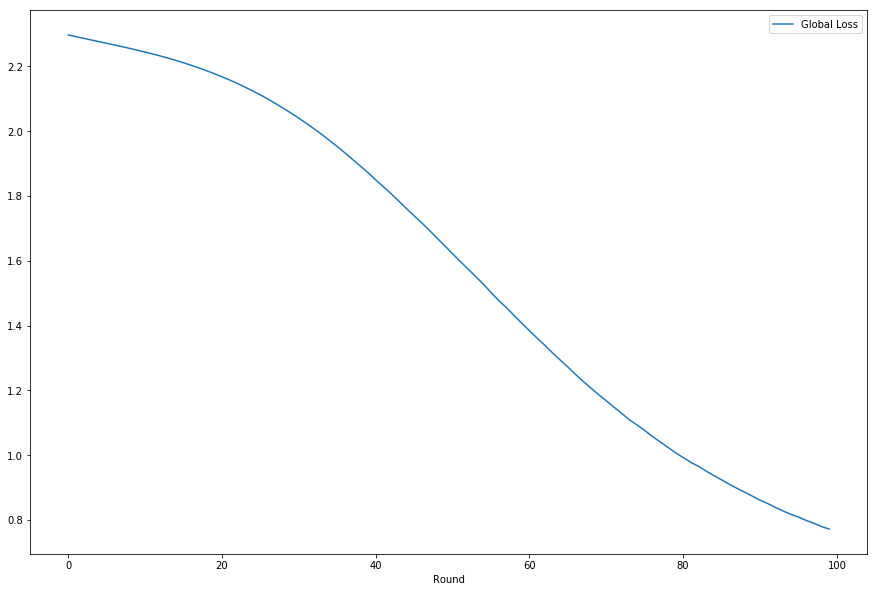

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss", )
ax.set_xlabel("Round");
ax.legend();

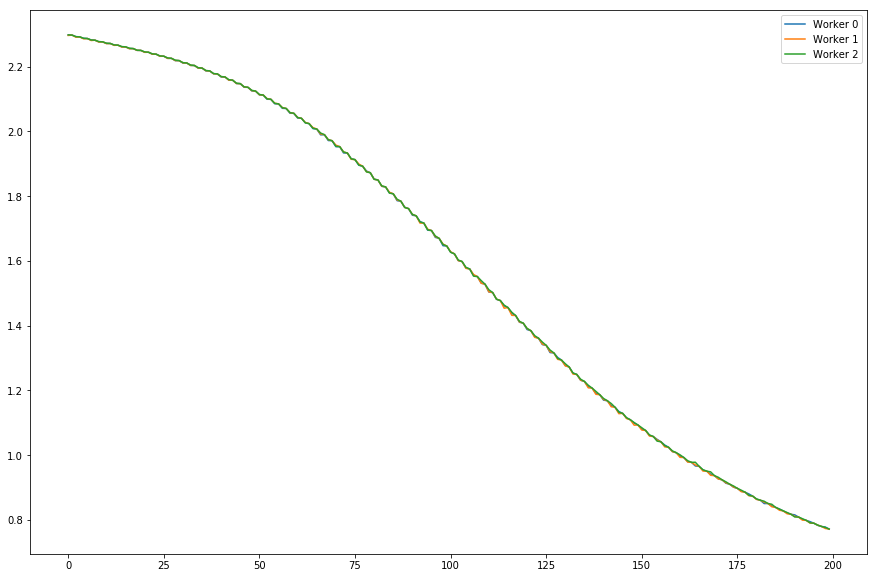

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))

for i in range(len(manager.worker_loss_histories)):
    ax.plot(manager.worker_loss_histories[i], label=('Worker ' + str(i)))
    ax.legend();

TODO: Write a bit of code that records the hyperparameters and saves the graphs, times and losses in a bundle for each run. Something like:

```
2019-05-06 21:02:50

# standard dataloader parameter
batch_size = 128

# biasing parameters
skew_bias = 0.3
loader_size = 8192
num_workers = 10

Stacked set creation time: 00:01:08

# training parameters
learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

Train time = 00:43:02

Final global loss: 0.48251
```

Well. I did this. And now the code is unreadable.

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - 

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?

In [19]:
# a little performance info on the run
run_data['Global End Time'] = time.time()
run_data['Global Time'] = run_data['Global End Time'] - run_data['Global Start Time']
run_data

{'Date': '2019-05-15 17:10:10',
 'Global Start Time': 1557954610.2368684,
 'Batch Size': 128,
 'Skew Bias': 0.5,
 'Examples Per Skewed Loader': 1024,
 'Number of Workers': 3,
 'Stacking Time': 27.910616636276245,
 'Stacking Time per Loader': 9.303538878758749,
 'Learning Rate': 0.01,
 'Epochs per Round': 1,
 'Federated Training Rounds': 100,
 'Federated Training Time': 585.4245042800903,
 'Final Global Loss': 0.7718092203140259,
 'Global End Time': 1557955236.9715736,
 'Global Time': 626.734705209732}

In [20]:
# leave a record of the run
# but it isn't valid JSON
import json 
with open('run_data.json', 'a') as file:
    file.write(json.dumps(run_data))
    file.write('\n\n')